# ML Challenge Problem 6 Part 6

Here I combine two models trained on the GPUs. The first predicts the pedestal, amplitude, and time for single pulse waveforms. The second predicts the number of pulses in the waveform. The second model is used to mask the results of the first so that the outputs will be identically A=0,t=-1 when no pulse is present. When it determines two pulses are present, it uses the results from the one pulse model to set the values of the first pulse and sets constant values of A=240 and t=40 for the second pulse. (Those values obtained from eyeballing the histograms of A2,t2 values for double pulse waveforms in the training set).

The first part of this notebook creates the hybrid model and then uses it to make predictions for training set. These are saved in the file *"model_pred_lawrence.csv"*. The second part uses the model to make predictions for the test set which is used for judging. These are saved in the file *"model_pred_lawrence_test_set.csv"*. Some plots of waveforms corresponding to different model predictions are shown at the bottom.

In [1]:
# Read the full data file into a dataframe
# This file does not have a header so we define the column names here explicitly

import pandas as pd
import numpy as np

TRAIN_FILE  = '/home/davidl/work2/2020.08.12.ML_challenge6/Aug_2020_ML_train.csv'

# Columns in input file. First 5 are labels
names = ['ped', 'A1', 'A2', 't1', 't2']

# Next 128 are features (waveform)
for i in range(0,128): names.append('s%03d' % i)

# Read file and print how many waveforms are found
df = pd.read_csv(TRAIN_FILE, names=names)
print('Number of waveforms: %d' % len(df.index))

Number of waveforms: 190071


### Load pre-trained models

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Input, Lambda, Conv1D, Concatenate
from tensorflow.keras.optimizers import SGD, Adamax, Adadelta, Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
import tensorflow.keras.backend as K
import tensorflow.keras.losses
import tensorflow as tf
import matplotlib.pyplot as plt

model_one_pulse = load_model('final_models/one_pulse_001')
model_Npulses = load_model('final_models/npulses_001')

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ts5gh_mx because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Define Final Model

In [3]:
# Used by Lambda function to coherse A1,t1 and A2,t2 into
# 0,-1 if number of indentified pulses indicates no pulse
def SeminalValues(inputs):
    A2_avg = 240.0
    t2_avg = 40.0

    mask = K.round(inputs[:,:3]) # one hot vector of 3 indicating whether there are zero(1,0,0), one(0,1,0), or two(0,0,1) pulses
    mask1  = mask[:,1] + mask[:,2] # Set A1,t1 if either 1 or 2 pulse waveform
    mask2  = mask[:,2]             # Set A2,t2 only if 2 pulse waveform
    print('mask:' + str(mask))
    print('mask1:' + str(mask1))
    print('mask2:' + str(mask2))
    print('mask[:,2]:' + str(mask[:,2]))

    A1_out = inputs[:,4]*mask1
    t1_out = inputs[:,5]*mask1 - (1-mask1)
    A2_out = A2_avg*mask2
    t2_out = t2_avg*mask2 - (1-mask2)

    tmp = inputs[:,4]*mask[:,1]
    print('A1_out: ' + str(A1_out))
    print('tmp: ' + str(tmp))
    
    A1_out = K.expand_dims(A1_out)
    A2_out = K.expand_dims(A2_out)
    t1_out = K.expand_dims(t1_out)
    t2_out = K.expand_dims(t2_out)

    outputs = K.concatenate([A1_out,A2_out,t1_out,t2_out])
    return outputs


# Define the final model using two pre-trained models an
# a Lambda layer coherse into final format
NINPUTS = 128

inputs          = Input(shape=(NINPUTS,1), name='waveform')
x_pulse_classes = model_Npulses(inputs)
x_pulse_values  = model_one_pulse(inputs)
x               = Concatenate(name='concatenate_layer1')([x_pulse_classes] + x_pulse_values)
outputs         = Lambda(SeminalValues, name='seminal_values')(x)

model  = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse', optimizer=Adam(), metrics=['mae', 'mse'])

model_one_pulse.summary()
model_Npulses.summary()
model.summary()

mask:Tensor("seminal_values/Round:0", shape=(None, 3), dtype=float32)
mask1:Tensor("seminal_values/add:0", shape=(None,), dtype=float32)
mask2:Tensor("seminal_values/strided_slice_3:0", shape=(None,), dtype=float32)
mask[:,2]:Tensor("seminal_values/strided_slice_4:0", shape=(None,), dtype=float32)
A1_out: Tensor("seminal_values/mul:0", shape=(None,), dtype=float32)
tmp: Tensor("seminal_values/mul_4:0", shape=(None,), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
waveform (InputLayer)           [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
time_conv1 (Conv1D)             (None, 97, 128)      4224        waveform[0][0]                   
_______________________________________________

### Create prediction using original training file

Here I create an output file in the format requested for the POTQ6 using the original training file. I did this originally and point Kishan to it so he could test it with his script for scoring models. 

In [4]:
mydf = df
y_labels = mydf.iloc[:,:5].to_numpy()
x_waveform = mydf.iloc[:,5:133]

y_pred = model.predict(x_waveform)
outdf = pd.DataFrame(y_pred, columns=['A1','A2','t1','t2'])
outdf.to_csv('model_pred_lawrence.csv', index=False)

mask:Tensor("functional_1/seminal_values/Round:0", shape=(None, 3), dtype=float32)
mask1:Tensor("functional_1/seminal_values/add:0", shape=(None,), dtype=float32)
mask2:Tensor("functional_1/seminal_values/strided_slice_3:0", shape=(None,), dtype=float32)
mask[:,2]:Tensor("functional_1/seminal_values/strided_slice_4:0", shape=(None,), dtype=float32)
A1_out: Tensor("functional_1/seminal_values/mul:0", shape=(None,), dtype=float32)
tmp: Tensor("functional_1/seminal_values/mul_4:0", shape=(None,), dtype=float32)


## Create Predictions for final TEST set

Here I create a prediction file for the final test set of the POTQ6. 

In [5]:

TEST_FILE  = '/home/davidl/work2/2020.08.12.ML_challenge6/Nov_2020_ML_Test_SET.csv'

# Only 128 samples representing waveforms in this file
names = []
for i in range(0,128): names.append('s%03d' % i)

# Read file and print how many waveforms are found
testdf = pd.read_csv(TEST_FILE, names=names)
print('Number of waveforms in TEST: %d' % len(testdf.index))

mydf = testdf
x_test_waveform = mydf.iloc[:,:128]

y_test_pred = model.predict(x_test_waveform)
outtestdf = pd.DataFrame(y_test_pred, columns=['A1','A2','t1','t2'])
outtestdf.to_csv('model_pred_lawrence_test_set.csv', index=False)
print('Number of waveforms in TEST output: %d' % len(outtestdf.index))

Number of waveforms in TEST: 26077
Number of waveforms in TEST output: 26077


## Plot Test set predictions

                   Num. total: 26077
             Num. zero pulses: 16981
           Num. with A1 pulse: 9094
           Num. with A2 pulse: 138
Num. with A1 but not A2 pulse: 8958
Num. with A2 but not A1 pulse: 2


,A1,A2,t1,t2
10763,0.0,240.0,57.804714,40.0
20849,0.0,240.0,32.429077,40.0


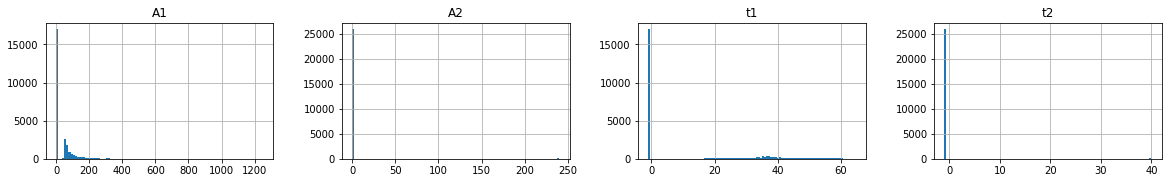

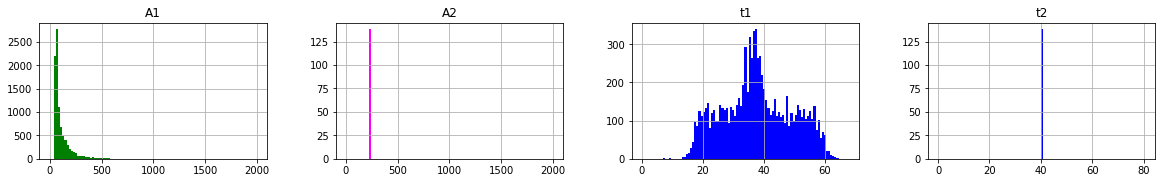

In [6]:
import matplotlib.pyplot as plt

# Plot all labels with default axes and no cuts
h = outtestdf.hist(column=['A1','A2','t1','t2'], bins=100, figsize=(20.0,2.5), layout=(1,4))

# Plot with zeros suppressed
fig, ax = plt.subplots(1,4, figsize=(20,2.5))

testdfA1 = outtestdf[outtestdf.A1 != 0]
testdfA1.hist(ax=ax[0], column=['A1'], bins=np.linspace(0.0, 2000.0, 100), color='green')

testdfA2 = outtestdf[outtestdf.A2 != 0]
testdfA2.hist(ax=ax[1], column=['A2'], bins=np.linspace(0.0, 2000.0, 100), color='magenta')

testdft1 = outtestdf[outtestdf.t1 >= 0]
testdft1.hist(ax=ax[2], column=['t1'], bins=np.linspace(0.0, 68.0, 100), color='blue')

testdft2 = outtestdf[outtestdf.t2 >= 0]
testdft2.hist(ax=ax[3], column=['t2'], bins=np.linspace(0.0, 80.5, 100), color='blue')

testdfno_pulses = outtestdf[(outtestdf.A1==0) & (outtestdf.A2==0)]
testdfA1_not_A2 = outtestdf[(outtestdf.A1!=0) & (outtestdf.A2==0)]
testdfA2_not_A1 = outtestdf[(outtestdf.A1==0) & (outtestdf.A2!=0)]

Ntot = len(testdf)
NA1  = len(testdfA1)
NA2  = len(testdfA2)
Nnone= len(testdfno_pulses)
NA1_not_A2 = len(testdfA1_not_A2)
NA2_not_A1 = len(testdfA2_not_A1)

print('                   Num. total: %d' % Ntot)
print('             Num. zero pulses: %d' % Nnone)
print('           Num. with A1 pulse: %d' % NA1)
print('           Num. with A2 pulse: %d' % NA2)
print('Num. with A1 but not A2 pulse: %d' % NA1_not_A2)
print('Num. with A2 but not A1 pulse: %d' % NA2_not_A1)

testdfA2_not_A1.head()

### Some odd waveforms

In [8]:
from IPython.display import Image, HTML, display
import png
import os

# Generate one PNG image file for the specified entry and dataframe.
# The drawlines option can set whether to draw lines between points.
# The prefix value will be prepended on the outpout filenames.
def MakeImage(irow, drawlines=False, waveforms=None, prefix='', dirname='.'):
    row = waveforms[irow]
    
    width  = 128
    height = 128+100
    img = []
    for y in range(height):
        r = [255]*width
        img.append(r)

    for icol in range(width):
        yval = int((100-int(row[icol]))/8)  # For positive pulses: height - (100-int(row[icol]))
        yval = min(height-1, max(0, yval))
        img[yval][icol] = 0
        
        # Optionally draw lines between the dots
        if drawlines:
            if icol>0 :
                ymid = (int)((yval + last_yval)/2)
                ylo = min(last_yval, ymid)
                yhi = max(last_yval, ymid)
                for ylin in range(ylo, yhi): img[ylin][icol-1] = 0
                ylo = min(ymid, yval)
                yhi = max(ymid, yval)
                for ylin in range(ylo, yhi): img[ylin][icol-1] = 0
            last_yval = yval
    fname = prefix+'waveform_%06d.png' % irow
    if dirname != '.':
        try:
            os.makedirs(dirname)
        except:
            pass  # assume excpetion is because it already exists
        fname = os.path.join(dirname, fname)
    with open(fname, 'wb') as f:    
        w = png.Writer(width, height, greyscale=True)
        w.write(f, img)
        #print('Wrote file: ' + fname)
    return fname

# Generate PNG files for several waveforms and then return an HTML string that displays
# them all on one row.
def MakeHTML(waveforms, Nentries=8, offset=0, prefix='', dirname='.', drawlines=True, mess=''):
    pngimages = [MakeImage(e+offset, drawlines=drawlines, waveforms=waveforms, prefix=prefix, dirname=dirname) for e in range(Nentries)]
    imgs_html = []
    for fname in pngimages:
        imgs_html.append("<img style='width: 128px; margin: 2px; border: 1px solid blue;' src='%s' />" % fname)

    html = '<table bordercolor="yellow">'
    html += '<tr><td colspan="%d" bgcolor="yellow" style="text-align:left"><font color="black">%s:%s</font></td></tr>' % (Nentries, prefix[:-1],mess)
    html += "<tr>"
    for a in imgs_html: html += '<td>' + a + '</td>'
    html += "</tr></table>"
    return html

# Create PNG files
# NOTE: These have the amplitudes reduced by a factor of 8 to give them better aspect ratios
waveforms = x_test_waveform.iloc[testdfno_pulses.index.to_list()].to_numpy()
display( HTML(MakeHTML(waveforms, prefix='nopulse_', dirname='nopulse_', Nentries=8, mess='Model identified no pulses in waveform')) )

waveforms = x_test_waveform.iloc[testdfA1_not_A2.index.to_list()].to_numpy()
display( HTML(MakeHTML(waveforms, prefix='A1_not_A2_', dirname='A1_not_A2_', Nentries=8, mess='Model identified one pulse in waveform')) )

waveforms = x_test_waveform.iloc[testdfA2.index.to_list()].to_numpy()
display( HTML(MakeHTML(waveforms, prefix='A2_', dirname='A2_', Nentries=8, mess='Model identified two pulses in waveform')) )

waveforms = x_test_waveform.iloc[testdfA2_not_A1.index.to_list()].to_numpy()
display( HTML(MakeHTML(waveforms, prefix='A2_not_A1_', dirname='A2_not_A1_', Nentries=2, mess='Model identified two pulses in waveform, but second amplitude of first was zero (???)')) )